In [1]:
import numpy as np

In [2]:
from sklearn.metrics import mean_squared_error , accuracy_score
import matplotlib.pyplot as plt

In [3]:
from IPython.display import Image

# Implementation of RBFNN 





### Firs we are going to generate the values for $x_i$ and $x_j$ using 
\begin{align}
         x_i = -2 + 0.2i\ \ \  \ \ \ \ \ \ \ \ i = 0,1,. . . ,20\\
         x_j = -2 + 0.2j\ \ \  \ \ \ \ \ \ \ \ j = 0,1,. . . ,20\\
         Where  -2 \le x_i , x_j \le 2
\end{align}
&emsp; To achieve this we created a function called generate

In [4]:
def generate():
  xi = []
  for i in range(21):
    temp = -2 + 0.2 * i
    xi.append(temp)
  xj = xi.copy()
  return np.array(xi) , np.array(xj)

#### Next we generate the training set which is 441 randomly sampled data points defined as
\begin{align}
x  =(x_i , x_j)
\end{align}
&ensp; To achieve this we create a function data_gen 

In [5]:
def data_gen(x_i , x_j):
  data = []
  for i in range(len(x_i)):
    for j in range(len(x_j)):
      tmp = x_j[np.random.choice(range(len(x_j)), replace=False)]
      data.append([xi[i] , tmp])
  return np.array(data) 

In [6]:
xi , xj = generate()
dataset = data_gen(xi , xj)
dataset.shape

(441, 2)

### Next we generate the labels for the dataset using 
\begin{align}
f(x)= 
\begin{cases}
    +1,& \text{if } \ \ \ x_1^2 + x_2^2 \leq 1\\
    -1,              & \text{if }\ \ \ x_1^2 + x_2^2 > 1
\end{cases}\\
      \text{Over a  region} -2< x_1 < 2 \ \text{and} -2 <  x_2 < 2  
\end{align}

&ensp; To achieve this we create a function called `calc`  this function determine the conditions 

&ensp; and the we also create another function `label_gen` generate the labels

In [7]:
def calc(x):
  tep = x[0] ** 2 + x[1] ** 2
  return  1 if (tep < 1 or tep == 1) else -1

In [8]:
def label_gen(dataset):
  labels = []
  for v in dataset:
    labels.append(calc(v))
  return np.array(labels)


In [9]:
labels = label_gen(dataset)


In [10]:
# count = 0 
# for i in labels:
#   if i == 1:
#     count+= 1
# print(count)

#### Next we create a function called `obtain_distance` to calculate the L2 Norm distance between datapoints and centriods 

In [11]:
def obtain_distance(c , d):
  sum = 0 

  for i in range( len( c ) ):

    sum += (c[i] - d[i])**2

  return np.sqrt( sum )  

Next we implement a kmeans clustering algorithm using a function we call `clustering`.

This function take in the dataset , the number of centroids desired and the maximum number of iterations

In [12]:
def clustering(X , num_cluster, max_it):
  #Radomly choosing the centroids
  np.random.seed(0)
  centers = X[np.random.choice( range( len(X) ) , num_cluster , replace=False )]
  
  # initializing the converger and iteration tracker
  converge = False

  current_it = 0 

  # Performing the kmeans clustering operation with help of a while loop
  
  while (not converge) and (current_it < max_it):
    # create a list holds items that belongs to each centroid(center) for each 
    # iteration
    groups = [[] for i in range( len( centers ) )]

    #iterate through the dataset
 
    for x in X:
      # create a list that hold the distance between a datapoint and all
      # the centers
      distnce_vals = []

      #iterate through the center and add items that belong to each center
      for c in centers:
        distnce_vals.append(obtain_distance(c , x))
      groups[int( np.argmin( distnce_vals ) )].append( x )

    groups = list( filter( None , groups ) )

    # store the current centers for convergence checking
    prev_centers = centers.copy()
    
    # clear the  centers array using reinitialization method
    centers = []

    # generaing new using the mean of each custer in groups 
    for k in groups:
      centers.append( np.mean( k , axis = 0 ) )
    
    #calculating the difference btw the sum of pervious centers and current
    #centers
    diff = np.abs( np.sum( prev_centers ) - np.sum( centers ) )
    
    # print('K-MEANS {}'.format(diff))

    converge = (diff == 0) 
     
    current_it += 1

  # std = np.mean([np.std(x) for x in groups])

  return np.array(centers)
          


#### Given that a method to obtain the center and the spread has been defined 

#### We then created a class to implemented the supervised learning aspected of 
#### RBFNN.

#### Here the RBF values for each node in the hidden layer is obtained using the  Gaussian kernel function defined as
\begin{align}
     rbf\_val = e^{- \frac{||x - c||^2}{2\sigma^2}}
\end{align}
#### Here  `c` is the vector denoting the center of the radial function
#### &emsp; `x` is the input vector
#### `|| x - c ||` is an L2 Norm distance between the input vector and the vector denoting the center of the RBF function.

Also to obtain the weight of the network we used the Least Squares Linear Regression equation
\begin{align}
     W = (G^T G)^{−1}G^T Y
\end{align}

#### The `check` argumeent passed to the call function defines centriods and spread parameter to 
#### use. when the value is `True`, the train dataset is used as the centroid while the spread parameter `std` passed as argument to the function is used , and this is done to meet up with the requirment of part one of question 3.When the value of `check` is `False` the centroid is generated using the `clustering` function defined above,which implements the kmeans clustering algorithm and the spread parameter is obtained from clustering function as well, here the value of the spread parameter is obtained as the the mean of the standard deviations of each cluster.This second aspect of `check` is done to meet the requirement of part 2 of question 3.


In [13]:
class RBFNN:

  def __init__(self, train_X , train_y ,test_X , test_y 
               , num_centers , num_class):

    self.train_X = train_X

    self.train_y = train_y

    self.test_X = test_X

    self.test_y = test_y

    self.num_centers = num_centers
    self.num_class = num_class


  # This function converts the lables into one hot encoded format 
  def one_hot_encoding(self, lab, num_class):
    # creating a matrix of  labels x number of classes
    arr = np.zeros((len(lab), num_class))

    # assigning the value 1 to position in the matrix that represent 
    # a value in the labels array
    for i in range(len(lab)):
        c = int(lab[i])
        if c == -1:
          arr[i][0] = 1 
        else:
          arr[i][c] = 1
    return np.array(arr)

  # Here we created a function that obtains the RBF value for each node in the
  # the hidden layer
  def rbf_val(self, x , mu , std):
    dist = obtain_distance(x , mu)

    return  np.exp(- dist **2 / (2 *  std** 2) )


  # Next we create a matrix containing the RFB vectors of each data point
  #using the a function rfb_mat 
  # Note that list_s is a list of spreads for each node in the hidden layer
  def rbf_mat(self ,  X , centers , list_s):
    RBF_Hidden = []
    for x in X:
      RBF_Hidden.append([ self.rbf_val( x , c , s ) for
                         ( c , s ) in zip(centers , list_s)])

    return np.array(RBF_Hidden)

  #Next we define a fit function("call") which will take as argument a variable
  #called par which is used to vary the spread for the nodes in the hidden layer
  def call(self,par,std, check):

    #Here we intialize the spread parameter
    self.std = std

    # First we check if the argument "check" is 0 
    # if check is 0 we self.centroids to the training dataset
    if(check == 0):
      self.centroids = self.train_X
      print(self.num_centers)
    #First we check if the argument "check" is 1 if check is 1 we obtain the 
    #centroid from the clustering function
    if(check == 1):
      self.centroids = clustering(self.train_X , self.num_centers, max_it=1000)
      print(self.num_centers)
    #First we check if the argument "check" is 2 if check is 2 we obtain the 
    #centroid by random selection from the training dataset
    if(check == 2):
      
      np.random.seed(0)
      self.centroids = self.train_X[np.random.choice( 
          range(len(self.train_X)),self.num_centers , replace=False)]
      print(len(self.centroids))

      
    
    #Next we add the par to the spread std 
    # and then create an array list_s whose lenght is the number of centers
    
    # self.s = self.std
    self.std +=par
    print(self.std)
    self.list_s = np.repeat(self.std,self.num_centers)

    #Next we forward propagate the training set and then obtain 
    # the RBF_list matrix 

    RBF_Train = self.rbf_mat(self.train_X , self.centroids , self.list_s)

    # Next we calculate the weights of the network by applying 
    # the formula above  
    self.one = self.one_hot_encoding(self.train_y,self.num_class)
    self.W = np.linalg.pinv(RBF_Train.T @ RBF_Train) @ RBF_Train.T @ self.one
    # self.W = np.dot(np.linalg.pinv(RBF_Train), self.one)
    # Next we used the weights obtained to get a one hot encoded 
    # output matrix for train set
    self.predict_t = RBF_Train @ self.W

    # Next we converted the output matrix to array of classes
    self.predict_t = np.array( [ np.argmax( k ) for  k in self.predict_t ] )
    # Here we convert the 0 values in the array to -1
    for i in range(len(self.predict_t)):
      if (self.predict_t[i] == 0):
        self.predict_t[i] = -1
        

    # Next  we calculate the training accuracy
    # error_t = self.predict_t - self.train_y

    # accuracy_train = (len( np.where(error_t == 0 )[0] )) / len(error_t) *100
    accuracy_train = accuracy_score(self.train_y , self.predict_t) * 100
    print(f"Training accuracy: {accuracy_train}%" )



    # Next we used the test set to obtain RBF matrix for the test set
    RBF_Test = self.rbf_mat(self.test_X , self.centroids , self.list_s)

    # Next we used the weights obtained to get a one hot encoded 
    # output matrix for test set
    self.predict = RBF_Test @ self.W

    # Next we converted the output matrix to array of classes
    self.predict = np.array( [ np.argmax( z ) for  z in self.predict ] ) 
    for i in range(len(self.predict)):
      if (self.predict[i] == 0):
        self.predict[i] = -1


    # Next  we calculate the testing accuracy
    # error = self.predict - self.test_y
    # accuracy_test = (len( np.where(error == 0 )[0] )) / len(error) *100
    accuracy_test = accuracy_score(self.test_y , self.predict) * 100
    print(f"Testing accuracy: {accuracy_test} %" )


    # Next we calculate the mean squared error
    self.mse = mean_squared_error(self.test_y , self.predict)
    return self.mse 



### Dataset Preparation 
&emsp; Here the we split the data 80 / 20 

In [14]:
# Here our goal is to split the data into train data and validation data 

def split_data(X, y, percent):
    #Created a dummy array with the size of the dataset
    np.random.seed(1) 
    arr_rand = np.random.rand(X.shape[0])

    #This creates a randomly populated array of boolean variables the length 
    # of the arr_rand
    split = arr_rand < np.percentile(arr_rand, percent)
    #Here the spliting for test and train is carried out using the 
    #array of boolean variables 
    X_train = X[split]  
    y_train = y[split]
    X_test =  X[~split]
    y_test =  y[~split]

    # print(f"{len(X_train)}, {len(y_train)}, {len(X_test)}, {len(y_test)}")
    return X_train, y_train, X_test, y_test

In [15]:
X_train , y_train , X_test, y_test = split_data(dataset, labels, 80)

## Considering Question 3 -> i
&emsp; Here we are told to vary the spread and report

&emsp; 1 -> a graph showing the relationship between spread values and means squared error.

&emsp; 2 - > The testing accuracy for each variation 
 
&emsp; 3 -> the training accuracy for each variation

&emsp; To achieve this we created an array containing 10 items which are values to be add to our original spread value 

### The orignal spread values is  `1.5`
### The variations are ` [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]`


In [16]:
sigma = 1.5
variations = [0,1,2,3,4,5,6,7,8,9,10]

In [17]:
#initializing the RBFNN class
num_centers = len(X_train)
rbf = RBFNN(X_train , y_train ,X_test , y_test , num_centers , 2)

In [ ]:
va_val = []
mse_list = []
for i in range(len(variations)):
  par = variations[i]
  temp = sigma + variations[i]
  mse = rbf.call(variations[i], sigma , 0)
  va_val.append(temp)
  mse_list.append(mse)

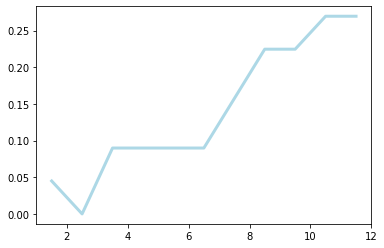

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(va_val, mse_list, color='lightblue', linewidth=3)
ax.set_xlim(auto = True)
plt.savefig('mse_vs_var1.png')

##  Discussion

#### The Training and Testing accuracy with their respective values of spread



Training accuracy&emsp;&emsp;&emsp;Testing accuracy&emsp;&emsp;&emsp;Spread value

 98.86%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;98.87%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;1.5


 97.16%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;100.0%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;2.5

  98.01%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;97.75%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;3.5

  98.01%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;97.75%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;4.5

  97.73%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;97.75%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;5.5

97.73%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;97.75%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;6.5

  97.73%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;97.75%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;7.5

  91.19%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;94.38%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;8.5

  91.19%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;94.38%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;9.5

  91.19%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;93.23%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;10.5

  91.19%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;93.25%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;2.5

![Spread Parameter variation Vs Mean Squard Error Q3-a](./mse_vs_var1.png)

#### From the graph we could deduce that at the initial value spread parameter  `1.5` the mean squared error was little bit above zero `0.05` and at `2.5` the mean squared error was at `0`, consequently as the value of the spread parameter increased the valued of the mean square error increase.One theory for this is, as the value of the spread parameter increases the the bell curve representing the Gaussian distribution i.e the `Radial Basis Function` becomes wider and flatter,which reduces its ability to non-linearly separate data points in different classes decreases.

## Considering Question 3 -> ii -> a
#### Here we are told to 

#### 1 Design another RBFNN with 150 centroids using the same spread parameter for each RBF kernal

#### 2 Generate the centroides by random selection from the input data

#### 2 Compare the result with that of the previous design 

#### To achieve this we intialized the RBFNN class again this time we set the `num_centers` to 150 and then called the call function with the `check` parameter set to `2` 

In [21]:
#initializing the RBFNN class again
rbf_1 = RBFNN(X_train , y_train ,X_test , y_test , 150 , 2)

In [ ]:
va_val_1 = []
mse_list_1 = []
for i in range(len(variations)):
  par = variations[i]
  temp_1 = sigma + variations[i]
  mse_1 = rbf_1.call(par,sigma , 2)
  va_val_1.append(temp_1)
  mse_list_1.append(mse_1)

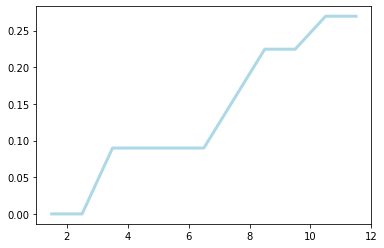

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(va_val_1, mse_list_1, color='lightblue', linewidth=3)
ax.set_xlim(auto = True)
plt.savefig('mse_vs_var2.png')

##  Discussion

#### The Training and Testing accuracy with their respective values of spread



Training accuracy&emsp;&emsp;&emsp;Testing accuracy&emsp;&emsp;&emsp;Spread value

 98.01%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;100.0%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;1.5


 98.30%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;100.0%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;2.5

  98.57%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;97.75%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;3.5

  98.86%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;97.75%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;4.5

  97.72%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;97.75%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;5.5

97.73%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;97.75%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;6.5

  97.73%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;97.75%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;7.5

  91.19%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;94.38%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;8.5

  91.19%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;94.38%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;9.5

  91.19%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;93.26%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;10.5

  91.19%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;93.26%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;11.5

![Spread Parameter variation Vs Mean Squard Error Q3-ii-a](./mse_vs_var2.png)

#### Looking at the table and the graph for both RBFNN designs we can deduce that the maximum mean squared error for both design are the same, and this is because `given enough RBF neurons, an RBFNN can define any arbitrarily complex decision boundary`, this implies that `352 RBF neurons` in the case where the training data are use as the neurons as well as `150 RBF neurons` are enough to define the decision boundary of this function approximation problem.Comparing the graph of `3 ii - a` and `3 -> ii -> b` we can see that there is no difference which implies that the method of choosing the `RBF neuron` does not have a huge impact if the number of RBF neuron is larger enough to approximate the decision boundary.

## Considering Question 3 -> ii -> b
#### Here we are told to 

#### 1 Design another RBFNN with 150 centroids using the same spread parameter for each RBF kernal

#### 2 Generate the centroids using `kmeans algorithm` implemented by the `clustering` function.

#### 2 Compare the result with that of the previous design 

#### To achieve this we used the RBFNN object instance initialized in 3 -> ii -> a and then called the call function with the `check` parameter set to `1` 



In [ ]:
va_val_2 = []
mse_list_2 = []
for i in range(len(variations)):
  par = variations[i]
  temp_2 = sigma + variations[i]
  mse_2 = rbf_1.call(par, sigma , 1)
  va_val_2.append(temp_2)
  mse_list_2.append(mse_2)

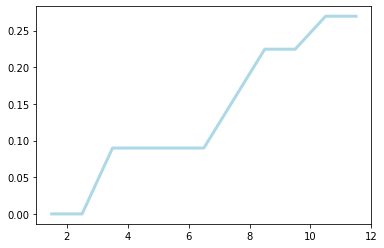

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(va_val_2, mse_list_2, color='lightblue', linewidth=3)
ax.set_xlim(auto = True)
plt.savefig('mse_vs_var3.png')

##  Discussion

##  Discussion

#### The Training and Testing accuracy with their respective values of spread



Training accuracy&emsp;&emsp;&emsp;Testing accuracy&emsp;&emsp;&emsp;Spread value

 98.01%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;100.0%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;1.5


 98.30%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;100.0%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;2.5

  98.57%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;97.75%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;3.5

  98.86%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;97.75%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;4.5

  97.72%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;97.75%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;5.5

97.73%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;97.75%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;6.5

  97.73%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;97.75%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;7.5

  91.19%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;94.38%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;8.5

  91.19%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;94.38%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;9.5

  91.19%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;93.26%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;10.5

  91.19%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;93.26%&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;11.5

![Spread Parameter variation Vs Mean Squard Error Q3-ii-b](./mse_vs_var3.png)

#### Looking at the table and the graph for both RBFNN designs we can deduce that the maximum mean squared error for both design are the same, and this is because `given enough RBF neurons, an RBFNN can define any arbitrarily complex decision boundary`, this implies that `352 RBF neurons` in the case where the training data are use as the neurons as well as `150 RBF neurons` are enough to define the decision boundary for this function approximation problem.